In [1]:
#import Numpy
import os
import numpy as np

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

#Now, import the FITS module inside Astropy
from astropy.io import fits

import math
import time
import numpy.ma as ma

#import package to caclulate remaining loop time 
from time import sleep
from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
print("I am in dir %s" % work_dir)

#We can go up by using the path.dirname
main_dir =os.path.dirname(work_dir)
print("Main directory is %s" % main_dir)

#We can then define the data directory using the os.path.join command
data_dir = os.path.join(main_dir,"data/secondData")
print("data dir is %s" % data_dir)

#..and we can define some output directory with the results
results_dir = os.path.join(main_dir,"results")

#if the directory does not exist, you can create it...
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    print("Directory %s created !" % results_dir)

I am in dir /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/code
Main directory is /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r
data dir is /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/data/secondData


In [3]:
#define the input file
input_filename = os.path.join(data_dir,"PSRJ2021_3deg_100mev_gti_bary.fits")

#First, open the file and check the information in it
fits_info = fits.open(input_filename)
#fits_info1 = fits.open(input_filename1)

#...like the number of HDU, in this case 5
fits_info.info()

Filename: /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/data/secondData/PSRJ2021_3deg_100mev_gti_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  EVENTS        1 BinTableHDU    257   26232R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     77   1753R x 2C   [D, D]   


In [4]:
#We will look at the EVENTS table (HDU=1)
table_header = fits_info[1].header
table_data = fits_info[1].data

table_data.columns

ColDefs(
    name = 'ENERGY'; format = 'E'; unit = 'MeV'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'L'; format = 'E'; unit = 'deg'
    name = 'B'; format = 'E'; unit = 'deg'
    name = 'THETA'; format = 'E'; unit = 'deg'
    name = 'PHI'; format = 'E'; unit = 'deg'
    name = 'ZENITH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'EARTH_AZIMUTH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'EVENT_ID'; format = 'J'
    name = 'RUN_ID'; format = 'J'
    name = 'RECON_VERSION'; format = 'I'
    name = 'CALIB_VERSION'; format = '3I'
    name = 'EVENT_CLASS'; format = '32X'
    name = 'EVENT_TYPE'; format = '32X'
    name = 'CONVERSION_TYPE'; format = 'I'
    name = 'LIVETIME'; format = 'D'; unit = 's'
    name = 'DIFRSP0'; format = 'E'
    name = 'DIFRSP1'; format = 'E'
    name = 'DIFRSP2'; format = 'E'
    name = 'DIFRSP3'; format = 'E'
    name = 'DIFRSP4'; format = 'E'
)

In [5]:
#Now convert the data to a Astropy Table object
from astropy.table import Table

evt_data = Table(table_data)
print("**Data contains %d events, this is the number of photons" % len(evt_data))

Nph = len(evt_data)

#convert data time in array
data_time = np.asarray(evt_data['TIME'])

**Data contains 26232 events, this is the number of photons


In [6]:
#-------------------DEFINE FUNCTION AND PARAMETERS FOR SCAN---------------------

#define the epoch as the central time of time intervall (T=54730-54820 MJD)
t0 = (251424001 + 243648001) /2

#define T as the difference of time intervall in MET
T = (251424001 - 243648001)

#define the initial values of f0,f1 and the spacing 
f_0start = 9.63935
f_1start = -8.8892e-12
df_0 = 0.15/T   #or 1/T 
df_1 = 0.3/T**2    #or 2/T**2

#define the array of f0,f1 to use for the scan
stepf0 = 1000
stepf1 = 50

f_0 = np.arange(f_0start-(stepf0/2)*df_0,f_0start+(stepf0/2)*df_0, df_0)
f_1 = np.arange(f_1start-(stepf1/2)*df_1,f_1start+(stepf1/2)*df_1, df_1)

print('**The number of step for f0 is %.0f, instead for f1 is %.0f' %(len(f_0), len(f_1)))

#define the number of harmonics
n = 8

#define function to calculate pulse phases
def Phi(f0,f1, time):
    phi = f0 * (time - t0) + f1/2 * (time - t0)**2
    frac_phi, int_phi = np.modf(phi)   #take the fractional part
    frac_phi[frac_phi<0] = frac_phi[frac_phi<0] + 1   #if phase is negative report it in [0,1] intervall
    return frac_phi

#define function for Ztest 
cos = np.empty(n+1)
sin = np.empty(n+1)

def Z2n(frac_phi):
    Z=0
    for k in range(1,n+1):
        cos[k] = np.sum(np.cos(2 * np.pi * k * frac_phi))
        sin[k] = np.sum(np.sin(2 * np.pi * k * frac_phi))
        Z += cos[k]**2 + sin[k]**2
    Z2n = (2/Nph) * Z
    return Z2n

#define function for scan
def main():
    for m in tqdm(range(len(f_0))):
        for s in range(len(f_1)):
            phase = Phi(f_0[m],f_1[s], data_time)
            Timing = Z2n(phase)
            x[s][m]= Timing
            Timing_list.append(Timing)
            f0_list.append(f_0[m])
            f1_list.append(f_1[s])
    return Timing_list, x, f0_list, f1_list


**The number of step for f0 is 1001, instead for f1 is 50


In [7]:
#----------------------------------SCAN OF f0 AND f1----------------------------------
start = time.time()


Timing_list = [] #list of Z2n values
f0_list = []
f1_list = []

#define a matrix whose indexes are the step of f0 and f1 and whose values are the Z2n
#calculated for those values of f0 and f1 (rows f1, columns f0)
x = np.empty((len(f_1),len(f_0))) 

#start scanning
Timing_list, x, f0_list, f1_list = main()

#found the maximum of Z2n
Z2n_max = np.max(Timing_list)
index_max = Timing_list.index(Z2n_max)
row , column = np.where(x == Z2n_max)


print('Maximum in Z-test : %f' %Z2n_max)
print('(f0,f1) : (%f,%e)' % (f0_list[index_max],f1_list[index_max]))
print('f0 step = %.0f\nf1 step = %.0f' %(column[0],row[0]))
print(time.time()-start)
Z2n_max, f0_list[index_max], f1_list[index_max], column[0], row[0]

  0%|          | 0/1001 [00:00<?, ?it/s]

Maximum in Z-test : 1253.811970
(f0,f1) : (9.639345,-8.889200e-12)
f0 step = 237
f1 step = 25
1810.3628096580505


(1253.8119695795526, 9.639344926697488, -8.889199999999993e-12, 237, 25)

In [8]:
#select energy bands
time1 = data_time[evt_data['ENERGY']>0.1e3]  #E>0.1 GeV (>100 MeV)
time2 = data_time[evt_data['ENERGY']>3e3]  #E>3 GeV (>3000 MeV)
time3 = data_time[(evt_data['ENERGY']<3e3) & (evt_data['ENERGY']>1e3)]  #1<E<3 GeV
time4 = data_time[(evt_data['ENERGY']<1e3) & (evt_data['ENERGY']>0.3e3)]  #0.3<E<1 GeV
time5 = data_time[(evt_data['ENERGY']<0.3e3) & (evt_data['ENERGY']>0.1e3)]  #0.1<E<0.3 GeV

In [9]:
#calculate the phases of photons using optimal parameters
phase_final1 = Phi(f0_list[index_max], f1_list[index_max], time1)
phase_double1 = np.concatenate((phase_final1, 1+phase_final1))

phase_final2 = Phi(f0_list[index_max], f1_list[index_max], time2)
phase_double2 = np.concatenate((phase_final2, 1+phase_final2))

phase_final3 = Phi(f0_list[index_max], f1_list[index_max], time3)
phase_double3 = np.concatenate((phase_final3, 1+phase_final3))

phase_final4 = Phi(f0_list[index_max], f1_list[index_max], time4)
phase_double4 = np.concatenate((phase_final4, 1+phase_final4))

phase_final5 = Phi(f0_list[index_max], f1_list[index_max], time5)
phase_double5 = np.concatenate((phase_final5, 1+phase_final5))

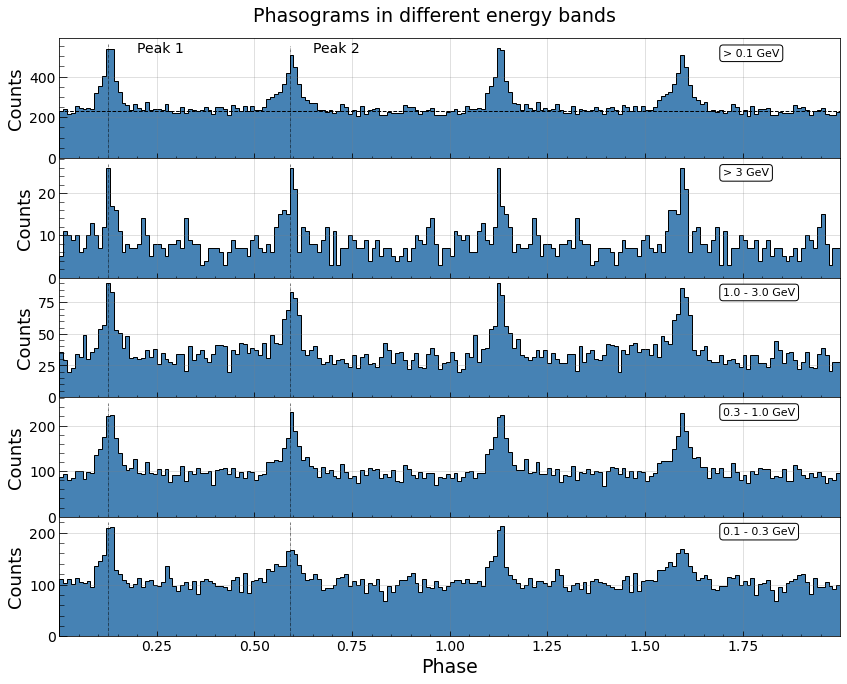

In [15]:
#SUBPLOTS
fig, axs = plt.subplots(5, sharex='col', figsize=(14,11))
plt.rc('font', size=14)

# Common axes limits
custom_xlim = (min(phase_double1), max(phase_double1))
plt.setp(axs, xlim=custom_xlim)

#delates space between plots
plt.subplots_adjust(wspace=0, hspace=0)

#Plots
axs[0].hist(phase_double1,bins=200,histtype='stepfilled',facecolor = 'steelblue', edgecolor='black')
axs[1].hist(phase_double2,bins=200,histtype='stepfilled',facecolor = 'steelblue', edgecolor='black')
axs[2].hist(phase_double3,bins=200,histtype='stepfilled',facecolor = 'steelblue', edgecolor='black')
axs[3].hist(phase_double4,bins=200,histtype='stepfilled',facecolor = 'steelblue', edgecolor='black')
axs[4].hist(phase_double5,bins=200,histtype='stepfilled',facecolor = 'steelblue', edgecolor='black')

#X label only on last one
axs[4].set_xlabel('Phase', fontsize = 19)

#Legends: text inside boxes
axs[0].text(0.85, 0.85, '> 0.1 GeV', fontsize=11, transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[1].text(0.85, -0.15, '> 3 GeV', fontsize=11, transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[2].text(0.85, -1.15, '1.0 - 3.0 GeV', fontsize=11, transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[3].text(0.85, -2.15, '0.3 - 1.0 GeV', fontsize=11, transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[4].text(0.85, -3.15, '0.1 - 0.3 GeV', fontsize=11, transform=axs[0].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

#Title
fig.suptitle('Phasograms in different energy bands ', y=0.92, fontsize=19)

#grids and other common properties
for ax in axs:
    ax.grid(b=True, color='grey', linestyle='-', alpha=0.3)
    ax.set_ylabel('Counts', fontsize = 18)
    ax.minorticks_on()
    ax.tick_params('x', which='major', direction='in', length=5.)
    ax.tick_params('y', which='major', direction='in', length=8.)
    ax.tick_params('y', which='minor', direction='in', length=5., left=True)
    ax.tick_params('x', which='minor', direction='in', length=2.5,bottom=True)
    
    
axs[0].text(0.20, 520, 'Peak 1')
axs[0].text(0.65, 520, 'Peak 2')
axs[0].plot([1.24115738e-01, 1.24115738e-01],[0,560], color='black',linewidth='0.5', linestyle='-.') #peak 1
axs[0].plot([5.89975178e-01, 5.89975178e-01],[0,550], color='black', linewidth='0.5', linestyle='-.') #peak 2    
axs[0].plot([0,2],[231.902778,231.902778], linestyle='--', linewidth='1', color = 'k', label='background')

axs[1].plot([1.24115738e-01, 1.24115738e-01],[0,27], color='black',linewidth='0.5', linestyle='-.') #peak 1
axs[1].plot([5.89975178e-01, 5.89975178e-01],[0,27], color='black', linewidth='0.5', linestyle='-.') #peak 2    

axs[2].plot([1.24115738e-01, 1.24115738e-01],[0,90], color='black',linewidth='0.5', linestyle='-.') #peak 1
axs[2].plot([5.89975178e-01, 5.89975178e-01],[0,90], color='black', linewidth='0.5', linestyle='-.') #peak 2    

axs[3].plot([1.24115738e-01, 1.24115738e-01],[0,250], color='black',linewidth='0.5', linestyle='-.') #peak 1
axs[3].plot([5.89975178e-01, 5.89975178e-01],[0,250], color='black', linewidth='0.5', linestyle='-.') #peak 2    

axs[4].plot([1.24115738e-01, 1.24115738e-01],[0,220], color='black',linewidth='0.5', linestyle='-.') #peak 1
axs[4].plot([5.89975178e-01, 5.89975178e-01],[0,220], color='black', linewidth='0.5', linestyle='-.') #peak 2    


#save figure in results directory
out_name = os.path.join(results_dir,"E_band.png")
plt.savefig(out_name, dpi = 300)
plt.show()